## Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Loading images

In [3]:
first_img_dir = "res19-near.png"
second_img_dir = "res20-far.png"

In [4]:
first_img = cv2.imread(first_img_dir)
second_img = cv2.imread(second_img_dir)

In [5]:
first_img.shape, second_img.shape

((725, 614, 3), (744, 632, 3))

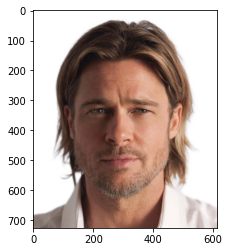

In [6]:
plt.imshow(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB));

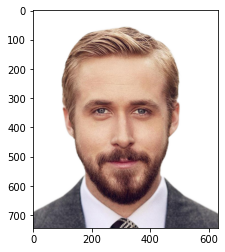

In [7]:
plt.imshow(cv2.cvtColor(second_img, cv2.COLOR_BGR2RGB));

## Face details matching

For matching the two faces, we need to match some correspoding points in each images. We'll pick 4 points to work with. the first two points for `j` scale and shift and the next two for `i` scale and shift. For the first two points, I suggest using the two eyes and for the other two, use chin and forhead.

In [8]:
def face_points(img_path):
    def draw_circle(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDBLCLK:
            color = (43, 57, 192)
            cv2.circle(img, (x, y), 3, color, -1)
            cv2.imshow('image', img)
            coords.append([y, x])
            if len(coords) == 4:
                cv2.destroyAllWindows()

    coords = []
    img = cv2.imread(img_path)
    
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',draw_circle)
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return np.array(coords, dtype=np.float32), img

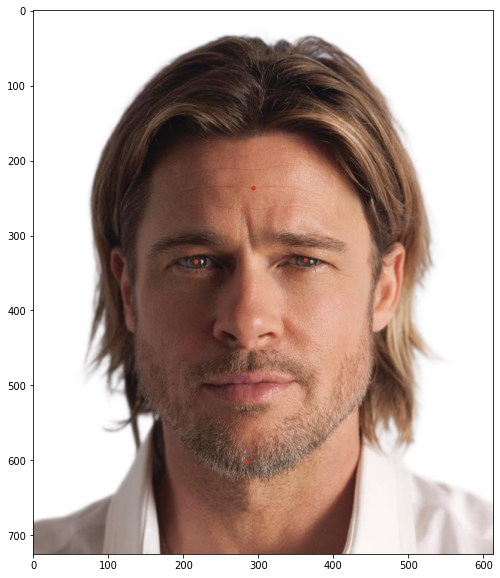

In [9]:
first_coords, first_circled_img = face_points(first_img_dir)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(first_circled_img, cv2.COLOR_BGR2RGB));

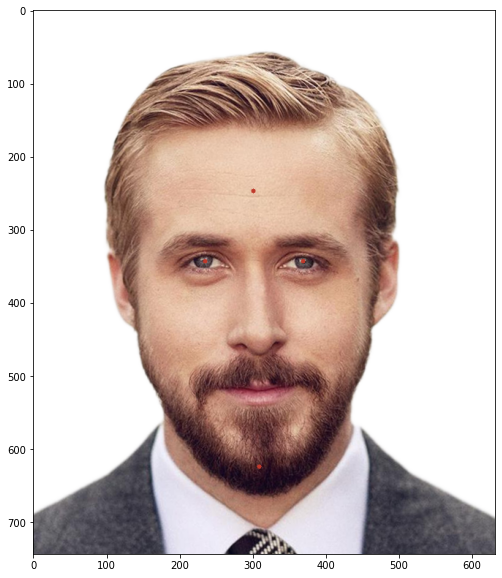

In [10]:
second_coords, second_circled_img = face_points(second_img_dir)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(second_circled_img, cv2.COLOR_BGR2RGB));

### `i` and `j` scaling

In [11]:
def points_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

first_j_dist = points_distance(first_coords[0], first_coords[1])
second_j_dist = points_distance(second_coords[0], second_coords[1])

first_i_dist = points_distance(first_coords[2], first_coords[3])
second_i_dist = points_distance(second_coords[2], second_coords[3])

print(first_i_dist, second_i_dist)
print(first_j_dist, second_j_dist)

366.08743 377.08487
146.0137 134.0


In [12]:
i_scale = second_i_dist/first_i_dist
j_scale = second_j_dist/first_j_dist

print(i_scale, j_scale)

1.0300405 0.9177221


In [13]:
scaled_first_img = cv2.resize(first_img, (int(first_img.shape[1]*j_scale), int(first_img.shape[0]*i_scale)))

In [14]:
new_coords = np.zeros((4, 2))
new_coords[:, 0] = first_coords[:, 0]*i_scale
new_coords[:, 1] = first_coords[:, 1]*j_scale
new_coords = new_coords.astype(np.int32)

new_coords

array([[345, 199],
       [343, 333],
       [621, 261],
       [244, 268]], dtype=int32)

### Shifting

In [15]:
def shift_img(im, i_diff, j_diff, fill_empty_with=255):
    new_im = np.full(im.shape, fill_empty_with)

    if i_diff >= 0 and j_diff >= 0:
        new_im[i_diff:, j_diff:] = im[:-i_diff, :-j_diff]
    elif i_diff >= 0 and j_diff < 0:
        new_im[i_diff:, :j_diff] = im[:-i_diff, -j_diff:]
    elif i_diff < 0 and j_diff >= 0:
        new_im[:i_diff, j_diff:] = im[-i_diff:, :-j_diff]
    else:
        new_im[:i_diff, :j_diff] = im[-i_diff:, -j_diff:]
    
    return new_im

Testing the above function

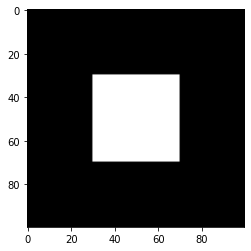

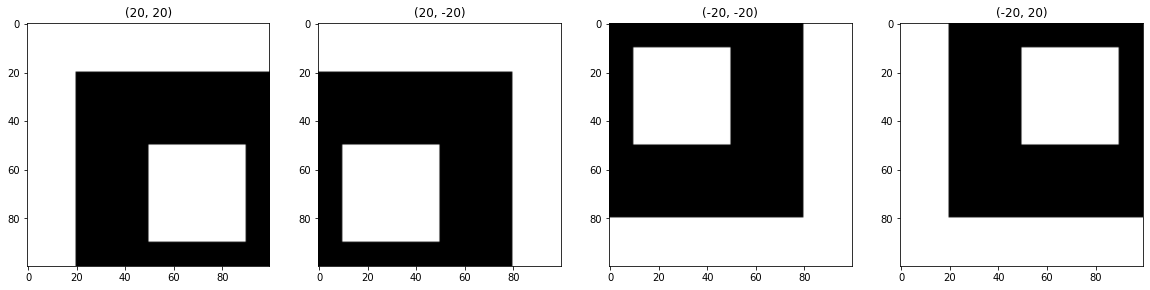

In [16]:
tst_img = np.zeros((100, 100))
tst_img[30:-30, 30:-30] = 255

plt.imshow(tst_img, cmap='gray');
plt.show();

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, (i_diff, j_diff) in enumerate([(20, 20), (20, -20), (-20, -20), (-20, 20)]):
    axs[i].imshow(shift_img(tst_img, i_diff, j_diff), cmap='gray')
    axs[i].set_title(str((i_diff, j_diff)))

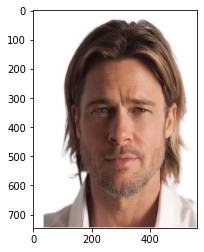

In [17]:
diff_vec = (second_coords[0] - new_coords[0]).astype(np.int16)

shifted_first_img = shift_img(scaled_first_img, diff_vec[0], diff_vec[1]).astype(np.uint8)

plt.imshow(cv2.cvtColor(shifted_first_img, cv2.COLOR_BGR2RGB));

### Croping images to to the same size

In [18]:
i_size = min(shifted_first_img.shape[0], second_img.shape[0])
j_size = min(shifted_first_img.shape[1], second_img.shape[1])

first_img_final = shifted_first_img[:i_size, :j_size]
second_img = second_img[:i_size, :j_size]

## Final images

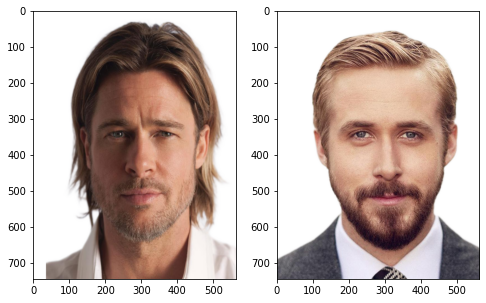

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(cv2.cvtColor(first_img_final, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(second_img, cv2.COLOR_BGR2RGB));

## Fourier transform and High/Loss pass filters

In [20]:
def normalize_between_zero_to_one(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

First image fourier transform

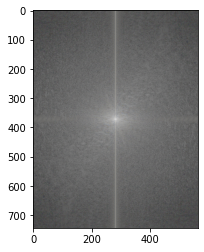

In [21]:
first_shifted_img = np.stack([np.fft.fftshift(np.fft.fft2(first_img_final[:, :, i])) for i in range(3)], axis=2)

ampiltude_img = np.abs(first_shifted_img)
log_amplitude_img = np.log(ampiltude_img)
plt.imshow(normalize_between_zero_to_one(log_amplitude_img));

Second image fourier transform

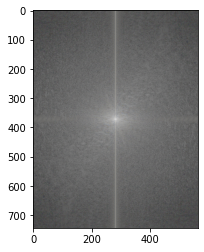

In [22]:
second_shifted_img = np.stack([np.fft.fftshift(np.fft.fft2(second_img[:, :, i])) for i in range(3)], axis=2)

ampiltude_img = np.abs(first_shifted_img)
log_amplitude_img = np.log(ampiltude_img)
plt.imshow(normalize_between_zero_to_one(log_amplitude_img));

This function generates a highpass/lowpass mask

**Choosing Filter:** I have also tested gaussian filters but the result from the below settings was better. So I decided to stick with this configuration.

In [23]:
def filter_generator(shape, radius=30, highpass=True):
    if highpass:
        filter = np.ones(shape)
    else:
        filter = np.zeros(shape)
    
    center_i, center_j = shape[0]//2, shape[1]//2
    for i in range(center_i-radius, center_i+radius):
        for j in range(center_j-radius, center_j+radius):
            if np.sqrt((i-center_i)**2 + (j-center_j)**2) <= radius:
                if highpass:
                    filter[i, j] = 0
                else:
                    filter[i, j] = 1
    
    return filter


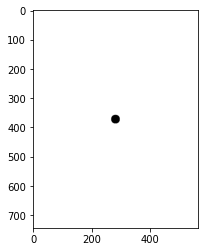

In [24]:
r = 15
HP_filter = filter_generator(first_shifted_img.shape[:2], radius=r, highpass=True)

plt.imshow(HP_filter, cmap='gray');

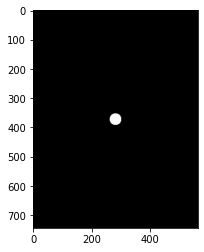

In [67]:
s = 20
LP_filter = filter_generator(first_shifted_img.shape[:2], radius=s, highpass=False)

plt.imshow(LP_filter, cmap='gray');

Get high/low frequencies from images

In [68]:
first_HP = np.stack([HP_filter]*3, axis=2) * first_shifted_img
second_LP = np.stack([LP_filter]*3, axis=2) * second_shifted_img

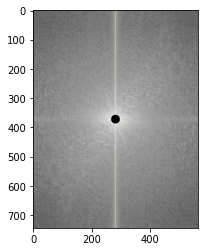

In [69]:
ampiltude_img = np.abs(first_HP)
log_amplitude_img = np.log(ampiltude_img+1)
plt.imshow(normalize_between_zero_to_one(log_amplitude_img));

Combine the results (by taking the average)

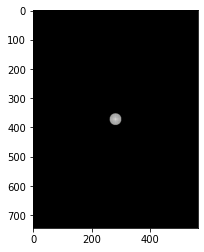

In [70]:
ampiltude_img = np.abs(second_LP)
log_amplitude_img = np.log(ampiltude_img+1)
plt.imshow(normalize_between_zero_to_one(log_amplitude_img));

In [27]:
mixed_img_fourier = (first_HP + second_LP)/2

In [28]:
mixed_img = np.stack([np.real(np.fft.ifft2(np.fft.ifftshift(mixed_img_fourier[:, :, i]))) for i in range(3)], axis=2).astype(np.float32)

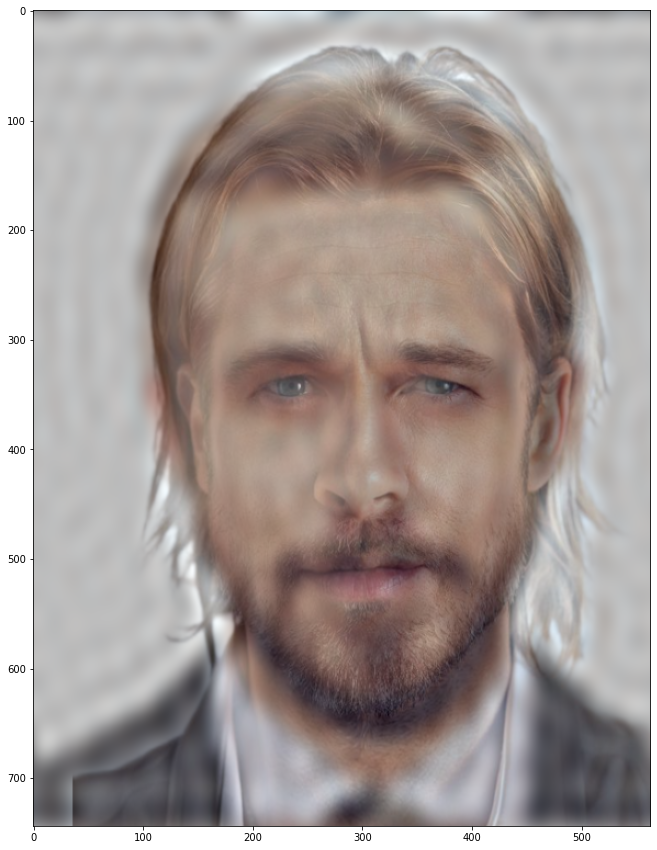

In [75]:
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(normalize_between_zero_to_one(mixed_img), cv2.COLOR_BGR2RGB));

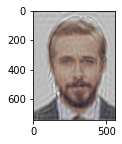

In [81]:
plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(normalize_between_zero_to_one(mixed_img), cv2.COLOR_BGR2RGB));